# Deep Learning - Dr. Tristan Behrens
## Today: End to End Learning for Self-Driving Cars.
---
<a href="https://colab.research.google.com/github/AI-Guru/fhws/blob/master/02%20Wahlvortrag%20Englisch/training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="margin-left:0"/>
</a>

---

<img src="https://ai-guru.s3.eu-central-1.amazonaws.com/FHWS/demo.gif" alt="Drawing" style="width:400px; margin-left:0" />

Paper: https://arxiv.org/abs/1604.07316  
Dataset: https://www.kaggle.com/roydatascience/training-car

What is the paper about?

- Nvidia.
- Training CNN on raw pixels.
- One camera mapped to steering commands.
- 72 hours of training data from two cars.
- No explicit decomposition of the problem.

## 1. Import modules.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm

## 2. Data.

### 2.1. Download datasets.

In [2]:
unprocessed_data_path = "training-car-unprocessed.p"
data_path = "training-car.p"

if os.path.exists(unprocessed_data_path) == False:
    !wget https://ai-guru.s3.eu-central-1.amazonaws.com/FHWS/training-car-unprocessed.p
else:
    print("Data already downloaded.")
        
if os.path.exists(data_path) == False:
    !wget https://ai-guru.s3.eu-central-1.amazonaws.com/FHWS/training-car.p
else:
    print("Data already downloaded.")
    

Data already downloaded.
Data already downloaded.


### 2.2. Load and inspect unprocessed data.

Firstly, we define a method for rendering random samples from any dataset.

In [3]:
def render_random_samples(images, targets):

    for i in range(3):

        _, _ = plt.subplots(1, 3, figsize=(15,15))

        subplot_index = 1
        for j in np.random.choice(list(range(len(images))), 3):

            image = images[j] / 255.0
            target = targets[j]
            plt.subplot(1, 3, subplot_index)
            plt.imshow(image, cmap="gray")
            plt.title("Steering {:0.2f}".format(target))
            subplot_index += 1
        plt.show()
        plt.close()

---
Then we load the unpropressed data. Note: Not used for training.

(300, 160, 320, 3)
(300,)


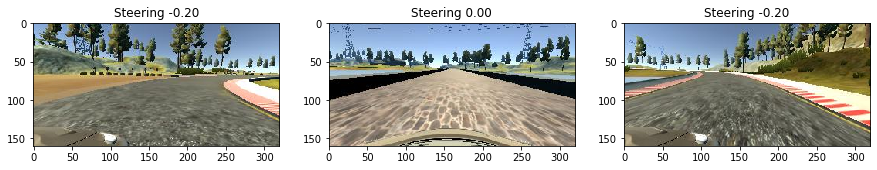

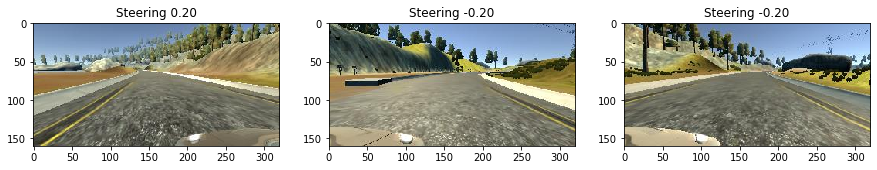

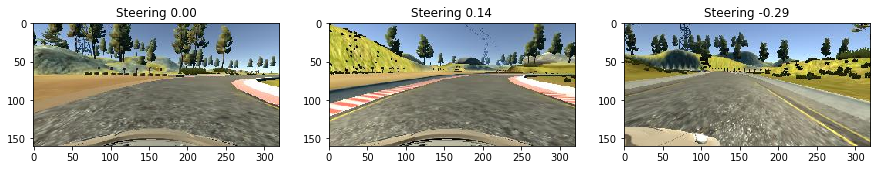

In [4]:
# Load pickle file.
with open(unprocessed_data_path, "rb") as file:
    images_unprocessed, targets_unprocessed = pickle.load(file)
print(images_unprocessed.shape)
print(targets_unprocessed.shape)

render_random_samples(images_unprocessed, targets_unprocessed)

### 2.3. About data preprocessing.

Steps:
1. Load image.
2. Convert to [HSV](https://en.wikipedia.org/wiki/HSL_and_HSV).
3. Discard H and S. Keep only V.
4. Resize to 40x40.

Preprocessing happened offline. See preprocessing notebook for details. Try at home.

---

**Questions**: 
- Why preprocessing?
- Especially: Why downscaling?

### 2.4. Load and inspect preprocessed data.

This is the data we will use for training.

(24108, 40, 40)
(24108,)


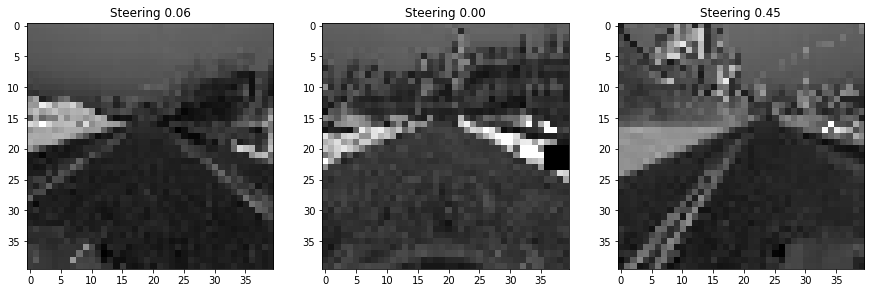

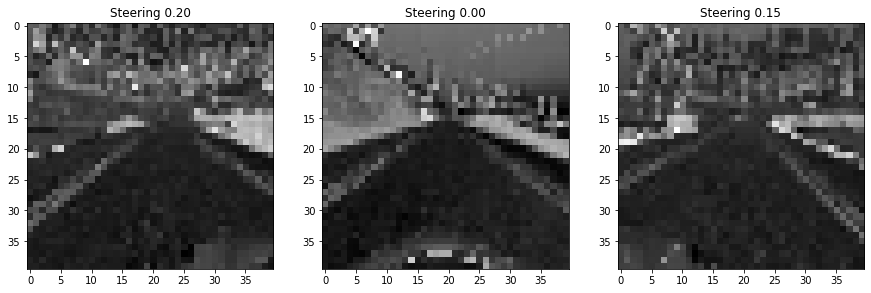

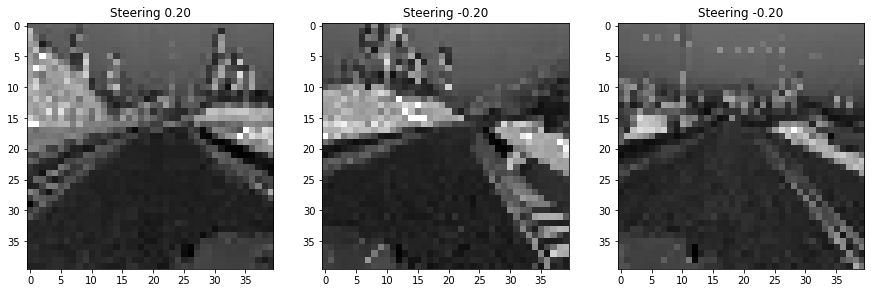

In [5]:
with open(data_path, "rb") as file:
    images, targets = pickle.load(file)
print(images.shape)
print(targets.shape)

render_random_samples(images, targets)

---

**Question:** How to find out if this really works?

### 2.5 Render distribution of targets.

Min: -1.1426954
Mean: 0.0040696445
STD: 0.20800088
Max: 1.2


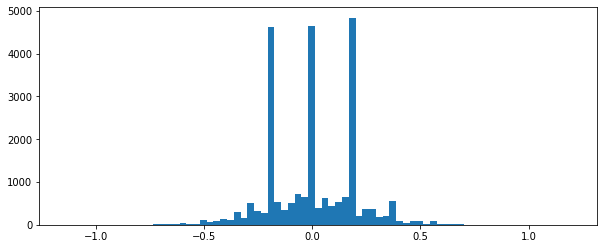

In [6]:
print("Min:", np.min(targets))
print("Mean:", np.mean(targets))
print("STD:", np.std(targets))
print("Max:", np.max(targets))

plt.figure(figsize=(10, 4))
plt.hist(targets, bins=75)
plt.show()
plt.close()

**Questions:**
- Is there a problem with this distribution?
- Is there a problem with the dataset size?

## 3. Designing and training a Neural Network.

### 3.1. Neural Network architecture.

- Lambda: Apply a function.
- Reshape: Change dimensions.
- Conv2D: Applying multiple filters on all possible locations.
- MaxPooling2D: Downsampling with maximum function.
- Flatten: Go down to one dimension.
- Dropout: Randomly set inputs to zero.
- BatchNormalization: Normalize inputs using mean and STD.
- Dense: Fully-connected.

In [7]:
model = models.Sequential()

model.add(layers.Lambda(lambda image: image / 127.5 - 1., input_shape=(40, 40)))
model.add(layers.Reshape((40, 40, 1)))

model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2), padding='valid'))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2), padding="valid"))

model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2), padding="valid"))

model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2), padding="valid"))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 40, 40)            0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        3

---
Compilation adds optimizer, loss and metrics.

- Nadam: Adam with Nesterov momentum.
- MSE: Mean squared error.
- MAE: Mean absolute error.

In [8]:
model.compile(
    optimizer=optimizers.Nadam(lr=0.0001), 
    loss="mse",
    metrics=["mae"])

### 3.2. Evaluate model quality (before training).

Render a random image, the target, the prediction and the error.

In [9]:
def render_sample():
    random_index = random.randint(0, len(images) - 1)
    image = images[random_index]
    target = targets[random_index]
    predicted_target = model.predict(np.array([image]))[0][0]
    plt.imshow(image, cmap="gray")
    error = np.abs(target - predicted_target)
    plt.title("Predicted: {:0.2f} Expected: {:0.2f} Error: {:0.2f}".format(predicted_target, target, error))

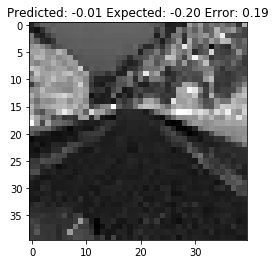

In [10]:
render_sample()

---

Get the error(s) for the entire dataset.

In [11]:
mse, mae = model.evaluate(images, targets)
print("MSE: {:0.2f}".format(mse))
print("MAE: {:0.2f}".format(mae))

24108/24108 [==============================] - 22s 911us/sample - loss: 0.0436 - mae: 0.1668
MSE: 0.04
MAE: 0.17


---
Visualize how well the model predicts.

In [12]:
def render_predictions():
    expected_targets = []
    predicted_targets = []
    for i in tqdm(range(0, 1000, 3)):
        image = images[i]
        expected_target = targets[i]
        predicted_target = model.predict(np.array([image]))[0][0]
        expected_targets.append(expected_target)
        predicted_targets.append(predicted_target)

    plt.figure(figsize=(10, 5))
    axes = plt.gca()
    axes.set_ylim([-0.5, 0.5])
    plt.plot(expected_targets, label="Expected")
    plt.plot(predicted_targets, label="Predicted")
    plt.legend()
    plt.show()
    plt.close()

100%|██████████| 334/334 [00:10<00:00, 30.66it/s]


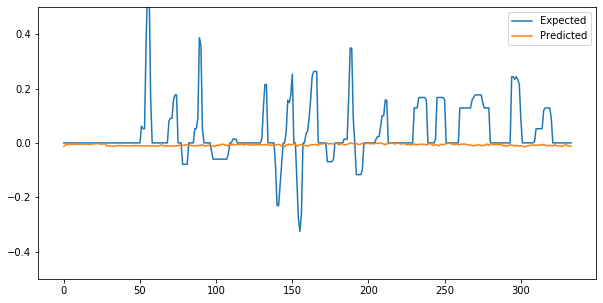

In [13]:
render_predictions()

### 3.3. Train the model.

In [14]:
history = model.fit(
    images, targets,
    epochs=10,
    batch_size=128,
    validation_split=0.2
).history

Train on 19286 samples, validate on 4822 samples
Epoch 1/10
19286/19286 [==============================] - 55s 3ms/sample - loss: 0.0328 - mae: 0.1357 - val_loss: 0.0396 - val_mae: 0.1583
Epoch 2/10
19286/19286 [==============================] - 49s 3ms/sample - loss: 0.0150 - mae: 0.0881 - val_loss: 0.0325 - val_mae: 0.1425
Epoch 3/10
19286/19286 [==============================] - 49s 3ms/sample - loss: 0.0130 - mae: 0.0802 - val_loss: 0.0250 - val_mae: 0.1247
Epoch 4/10
19286/19286 [==============================] - 52s 3ms/sample - loss: 0.0118 - mae: 0.0762 - val_loss: 0.0176 - val_mae: 0.1017
Epoch 5/10
19286/19286 [==============================] - 55s 3ms/sample - loss: 0.0112 - mae: 0.0736 - val_loss: 0.0125 - val_mae: 0.0801
Epoch 6/10
19286/19286 [==============================] - 51s 3ms/sample - loss: 0.0108 - mae: 0.0721 - val_loss: 0.0111 - val_mae: 0.0747
Epoch 7/10
19286/19286 [==============================] - 47s 2ms/sample - loss: 0.0103 - mae: 0.0700 - val_loss: 0.0

In [15]:
#model.save("model.h5")
#pickle.dump(history, open("history.p", "wb"))

model = models.load_model("model.h5")
history = pickle.load(open("history.p", "rb"))

---
Render the training history.

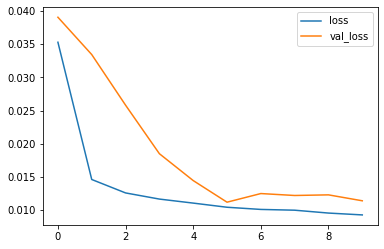

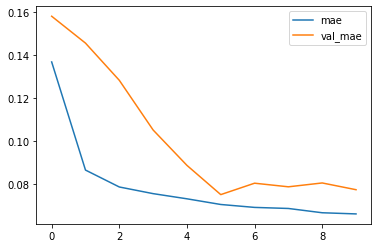

In [16]:
# MSE.
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.show()
plt.close()

# MAE.
if "mae" in history:
    plt.plot(history["mae"], label="mae")
    plt.plot(history["val_mae"], label="val_mae")
    plt.legend()
    plt.show()
    plt.close()
elif "mean_absolute_error" in history:
    plt.plot(history["mean_absolute_error"], label="mean_absolute_error")
    plt.plot(history["val_mean_absolute_error"], label="val_mean_absolute_error")
    plt.legend()
    plt.show()
    plt.close()  

**Questions:**
- What do we see here?
- How good is the Neural Network?
- Which plot is the most important one?

### 3.4. Evaluate model quality (after training).

Render a random image, the target, the prediction and the error.

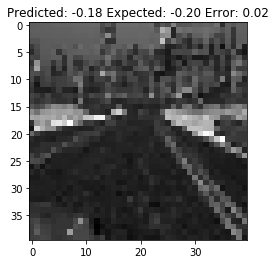

In [17]:
render_sample()

---

Get the error(s) for the entire dataset.

In [18]:
mse, mae = model.evaluate(images, targets)
print("MSE: {:0.2f}".format(mse))
print("MAE: {:0.2f}".format(mae))

24108/24108 [==============================] - 17s 691us/sample - loss: 0.0099 - mae: 0.0695
MSE: 0.01
MAE: 0.07


---
Visualize how well the model predicts.

100%|██████████| 334/334 [00:07<00:00, 46.33it/s]


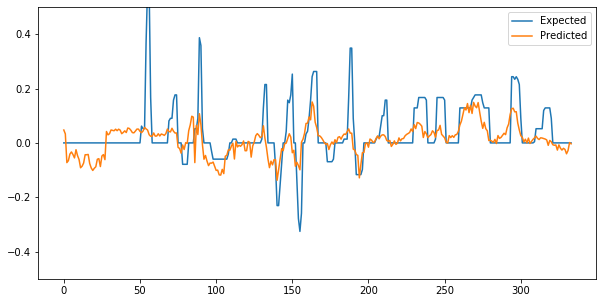

In [19]:
render_predictions()

## 4. Summary and outlook.

Summary:

- Convolutional Neural Networks can solve Autonomous Driving.
- Input comes from camera, output is steering.
- A lot of data is necessary.
    
Outlook:

- Train on way more data.
- Have a closer look at how convolutions and pooling-layers work.
- Train on more than steering, for example throttle and brake.
- [Autonomous Drone Navigation with Deep Learning](https://www.youtube.com/watch?v=H7Ym3DMSGms).

## References.

- https://www.manning.com/books/deep-learning-with-python
- https://www.deeplearningbook.org